### Pretraining on an auxiliary task. 
- In this exercise you will build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data. Start by building two DNNs (let’s call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add a single output layer on top of both DNNs. You should use TensorFlow’s concat() function with axis=1 to concatenate the outputs of both DNNs along the horizontal axis, then feed the result to the output layer. This output layer should contain a single neuron using the logistic activation function. 

- Split the MNIST training set in two sets: split #1 should containing 55,000 images, and split #2 should contain contain 5,000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes.

- Train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not. 

- Now create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on with 10 neurons. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class.

### Prepare Data

In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_all = x_train_all.reshape(-1, 28*28)/255.0

x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, test_size=5000)

/Users/devbhadurkhadka/.pyenv/versions/anaconda3-5.2.0/envs/scikit_practice/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib.pyplot as plt

def show_digits(X_batch):
    batch_size=len(X_batch)
    plt.figure(figsize=(3, 3 * batch_size))
    plt.subplot(121)
    plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", 
               interpolation="nearest")
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", 
               interpolation="nearest")
    plt.axis('off')
    plt.show()

(55000, 2, 784)
[1. 1. 1. 0. 0.]


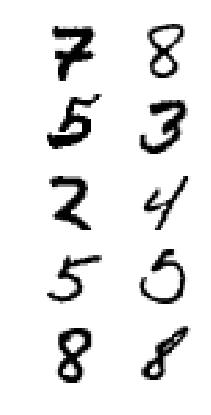

In [3]:
def get_compare_dataset(x_train, y_train):
    
    x_images1, x_images2, is_equal = [[],[],[]]
    for val in np.unique(y_train):
        indxes = np.arange(len(y_train), dtype=np.int32)
        val_bool_index = (y_train==val)
        
        val_indxes = indxes[val_bool_index]
        other_indxes = indxes[~val_bool_index]
        
        half_len = len(val_indxes)//2
        x_images1.append(x_train[np.random.choice(val_indxes, half_len)])
        x_images2.append(x_train[np.random.choice(val_indxes, half_len)])
        is_equal.append(np.zeros(half_len))
        
        
        other_len = len(val_indxes) - half_len
        x_images1.append(x_train[np.random.choice(val_indxes, other_len)])
        x_images2.append(x_train[np.random.choice(other_indxes, other_len)])
        is_equal.append(np.ones(other_len))
        
    x_images1, x_images2, is_equal = (np.concatenate(x_images1), np.concatenate(x_images2) \
                ,np.concatenate(is_equal))

    x_images = np.c_[x_images1, x_images2].reshape(-1,2,x_train.shape[1])

    shufffle_index = np.random.permutation(len(is_equal))
    
    return x_images[shufffle_index], is_equal[shufffle_index]
 
## TEST
x_images, is_equal = get_compare_dataset(x_train, y_train)
print(x_images.shape)
rnd_indx = np.random.choice(len(is_equal), 5)
print(is_equal[rnd_indx])
show_digits(x_images[rnd_indx])

In [4]:
x_images, is_equal = get_compare_dataset(x_train, y_train)

### Create Class DNN_Comparer

In [ ]:
from importlib import reload

import my_libs.dnn
reload(my_libs.dnn)

from my_libs.dnn import DNN_Classifier, get_connected_layers, get_optimizer_op
class DNN_Comparer():
    
    def __init__(self, n_hidden_layers=None, n_neurons=None, n_outputs=None, 
                 activation=tf.nn.elu, optimizer=tf.train.AdamOptimizer,  learning_rate=0.01, 
                 batch_norm_momentum=None, batch_size=50, dropout_rate=None):
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimizer = optimizer
        self.batch_norm_momentum = batch_norm_momentum
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.n_outputs = n_outputs
        self._session = None
    
    def _create_graph(self):
        tf.reset_default_graph()
        self._graph = tf.Graph()
        with self._graph.as_default():
        
            self._images = tf.placeholder(shape=(None, 2, 28*28), dtype=np.float32,name="x")
            self._image1, self._image2 = tf.unstack(self._images, axis=1)
            
            self._is_equal = tf.placeholder(shape=(None), dtype=np.bool,name="y")

            self._is_training = tf.placeholder_with_default(False,shape=(), name="is_training")


            with tf.variable_scope("dnn1"):
                dnn1 = get_connected_layers(self._image1, self.n_hidden_layers, self.n_neurons,
                                          activation=self.activation, 
                                   batch_norm_momentum=self.batch_norm_momentum, 
                                   dropout_rate=self.dropout_rate, is_training=self._is_training)
                
            with tf.variable_scope("dnn2"):
                dnn2 = get_connected_layers(self._image1, self.n_hidden_layers, self.n_neurons,
                                      activation=self.activation, 
                               batch_norm_momentum=self.batch_norm_momentum, 
                               dropout_rate=self.dropout_rate, is_training=self._is_training)
            
            combined_dnn = tf.concat([dnn1, dnn2], axis=1, name="combined_dnn")
            
            hidden_new = tf.layers.dense(combined_dnn, 10, name="hidden_new")
            self._output = tf.layers.dense(hidden_new, 1, name="output")
            
            is_equal_float=tf.cast(self._is_equal, np.float32)
            entropy=tf.nn.sigmoid_cross_entropy_with_logits(labels=is_equal_float, 
                                                            logits=self._output)
            
            self._loss = tf.reduce_mean(entropy)
            
            self._optimizer_op = get_optimizer_op(self.optimizer, self._loss, 
                                                  self.learning_rate)
            
            self._batch_norm_update_ops = self._graph.get_collection(tf.GraphKeys.UPDATE_OPS)
            
            self._preds = tf.greater_equal(self._output, 0)
            self._accuracy = tf.cast(tf.equal(self._preds,self._is_equal), np.float32)
            
            self._init = tf.global_variables_initializer()
        
    def test(self):
        self._create_graph()
        with tf.Session(graph=self._graph) as sess:
            sess.run(self._init)
            acc=self._accuracy.eval(feed_dict={
                self._images: x_images[:300],
                self._is_equal: is_equal[:300]
            })
        print(np.unique(acc,return_counts=True))
            
    
## Test Create Graph
# comparer = DNN_Comparer(5, 100)
# comparer._create_graph()

## Test
comparer = DNN_Comparer(5, 100)
comparer.test()

In [39]:
dnn = DNN_Comparer(5, 100)
dnn.test()


W0905 10:30:49.221084 4712965568 deprecation_wrapper.py:119] From /Volumes/Projects/Machine Learning/tensorflow_practice/my_libs/dnn.py:19: The name tf.get_variable_scope is deprecated. Please use tf.compat.v1.get_variable_scope instead.

W0905 10:30:49.222267 4712965568 deprecation.py:323] From /Volumes/Projects/Machine Learning/tensorflow_practice/my_libs/dnn.py:29: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


dnn1


W0905 10:30:50.393679 4712965568 deprecation.py:506] From /Users/devbhadurkhadka/.pyenv/versions/anaconda3-5.2.0/envs/scikit_practice/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


dnn2


W0905 10:30:50.592252 4712965568 deprecation.py:323] From /Users/devbhadurkhadka/.pyenv/versions/anaconda3-5.2.0/envs/scikit_practice/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


NameError: name 'get_optimizer_op' is not defined

In [47]:
tf.nn.l2_loss?

In [39]:
tf.Graph.get_name_scope?